In [2]:
!pip install scikit-learn keras-tuner git+https://github.com/paulgavrikov/visualkeras.git pydot pydotplus tf-nightly
!apt update
!apt install graphviz xxd --assume-yes
!python --version

  Cloning https://github.com/paulgavrikov/visualkeras.git to /tmp/pip-req-build-y3m2xiyz
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras.git /tmp/pip-req-build-y3m2xiyz
  Resolved https://github.com/paulgavrikov/visualkeras.git to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]        
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]  
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [31.2 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [2538 kB]
Get:7 http://se

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import keras_tuner
import tensorflow as tf
import keras

from keras import layers
from keras.utils import timeseries_dataset_from_array, to_categorical
from keras.callbacks import EarlyStopping
import visualkeras
from PIL import ImageFont
import logging
from enum import Enum
import itertools
import os
import pickle
import re
import random
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from utils import load_gesture_samples, GestureNames, split_data_between_participants, normalize_dataset

2023-06-20 13:29:28.918238: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-20 13:29:28.986841: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7630] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-06-20 13:29:28.986880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-06-20 13:29:28.986895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1500] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-20 13:29:29.003889: I tensorflow/core/platform/cpu_feature_g

In [104]:
!nvidia-smi

Tue May 23 10:11:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
| 50%   56C    P3    51W / 290W |   7358MiB /  8192MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
print(tf.__version__)

print('1: ', tf.config.list_logical_devices())
print('2: ', tf.test.is_built_with_cuda())
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.14.0-dev20230620
1:  [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2:  True
3:  /device:GPU:0
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


2023-06-20 13:29:36.268658: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 13:29:36.353140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 13:29:36.353630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 13:29:36.359321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:953] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-20 13:29:36.359570: I tensorflow/compile

In [5]:
# Setup logger
logging.basicConfig(level=logging.DEBUG,
                    force = True)

log = logging.getLogger("CSE3000")
log.setLevel(logging.INFO)

In [6]:
# Utility functions cell
RANDOM_SEED = 1000


np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


class Hand(Enum):
    right = "right_hand"
    left = "left_hand"


class GestureException(Exception):
    pass


class Gestures(Enum):
    SWIPE_LEFT = 0, 'swipe_left'
    SWIPE_RIGHT = 1, 'swipe_right'
    SWIPE_UP = 2, 'swipe_up'
    SWIPE_DOWN = 3, 'swipe_down'
    ROT_CW = 4, 'clockwise'
    ROT_CCW = 5, 'counter_clockwise'
    TAP = 6, 'tap'
    DOUBLE_TAP = 7, 'double_tap'
    ZOOM_IN = 8, 'zoom_in'
    ZOOM_OUT = 9, 'zoom_out'

    def __new__(cls, value, name):
        member = object.__new__(cls)
        member._value_ = value
        member.fullname = name
        return member

    def __int__(self):
        return self.value

    def __str__(self):
        return self.fullname

    @staticmethod
    def from_name(name: str):
        try:
            return next(g for g in Gestures if g.fullname == name)
        except StopIteration:
            raise GestureException("No gesture with name '%s' found..." % name)


class LoadGestureException(Exception):
    pass


def load_gesture_samples(gesture: Gestures, hand: Hand = Hand.right, skip_old_data: bool = True):
    result = []
    base_path = f"gestures_data/gestures/{gesture.fullname}/{hand.value}"
    log.debug("Loading gestures from base path: %s" % base_path)
    folder_items = os.listdir(base_path)

    # Filter on the .pickle extension
    filtered_ext = list(filter(lambda x: re.search(r'\.pickle$', x) is not None, folder_items))

    if len(filtered_ext) == 0:
        raise LoadGestureException("No gestures found in folder: %s" % base_path)

    for item in filtered_ext:
        r_match = re.match(r'candidate_(\w+).pickle$', item)
        if r_match is None:
            raise LoadGestureException("Incorrectly formatted data file name: %s" % item)

        candidate_id = r_match.group(1)
        with open(os.path.join(base_path, item), 'rb') as f:
            while True:
                try:
                    data_contents = pickle.load(f)

                    if isinstance(data_contents, dict):
                        if 'target_gesture' in data_contents:
                            # Data v3
                            # print(data_contents)
                            data_contents['gesture'] = Gestures.from_name(data_contents['target_gesture'])
                            # data_contents['all_data'] = data_contents['data']
                            # print(type(data_contents['data']))
                            # data_contents['data'] = list(map(lambda x: x['data'], data_contents['data']))
                            result.append(data_contents)
                        else:
                            # Data v2
                            data_contents['gesture'] = Gestures.from_name(data_contents['gesture'])
                            if not skip_old_data:
                                result.append(data_contents)
                    else:
                        # Data loader v1
                        data = {
                            'data': data_contents,
                            'gesture': gesture,
                            'candidate': candidate_id
                        }
                        if not skip_old_data:
                            result.append(data)
                except EOFError:
                    break

    return result


def split_data_between_participants(data, ratio = 0.7, expected_input_shape = (100, 3), dtype = np.int16):
    lb_candidate = lambda x: x['candidate']

    # For itertools.groupby to work we need to sort the data first
    data.sort(key=lambda x: x['candidate'])

    participants = set(map(lb_candidate, data))
    amount_measurements = len(data)
    amount_participants = len(participants)

    log.debug("Participants: %s" % participants)
    log.info("Got dataset for %d participants with %d measurements total" % (amount_participants, amount_measurements))

    amount_train = int(amount_measurements * ratio)
    amount_test = amount_measurements - amount_train
    log.info("Estimating %d measurements for training and %d measurements for test (ratio: %0.1f)" % (amount_train, amount_test, ratio))

    train_data = []
    train_data_outcomes = []

    test_data = []
    test_data_outcomes = []

    train_candidates = set()
    test_candidates = set()

    # Group the data per participant as that is the recommended method for training models
    for participant, d in itertools.groupby(data, lb_candidate):
        d_list = list(d)

        # if participant == 'A3':
        #     continue

        for data_point in d_list:
            try:
                if len(train_data) < amount_train:
                    assert data_point['data'].shape == expected_input_shape
                    train_candidates.add(participant)
                    train_data.append(data_point['data'])
                    train_data_outcomes.append(data_point['gesture'])
                else:
                    test_candidates.add(participant)
                    test_data.append(data_point['data'])
                    test_data_outcomes.append(data_point['gesture'])
                    # test_data.extend([p['data'] for p in d_list])
                    # test_data_outcomes.extend([p['gesture'].value for p in d_list])
            except AssertionError as e:
                log.error("Could not load gesture %s of participant %s (expected shape: %s but got %s)" % (data_point['gesture'], participant, expected_input_shape, data_point['data'].shape))

    log.info("Train candidates: %s\tTest candidates: %s" % (train_candidates, test_candidates))

    return (np.array(train_data, dtype=dtype), np.array(train_data_outcomes, dtype=dtype)), (np.array(test_data, dtype=dtype), np.array(test_data_outcomes, dtype=dtype))

def split_new(dataset, ratio: float = 0.7, skip_candidates: list = None):
    if skip_candidates is None:
        skip_candidates = []

    dataset.sort(key=lambda x: x['candidate'])

    candidate_map = {}
    for c, data in itertools.groupby(dataset, lambda x: x['candidate']):
        if c not in skip_candidates:
            candidate_map.setdefault(c, list(data))

    split_amount = int(len(candidate_map) * ratio)

    train = dict(itertools.islice(candidate_map.items(), split_amount))
    test = dict(itertools.islice(candidate_map.items(), split_amount, len(candidate_map)))

    log.info("Train candidates: %s \t Test candidates: %s" % (list(train.keys()), list(test.keys())))

    return train, test

def extract_features(data: dict, num_classes = len(Gestures), expected_input_shape = (100, 3), dtype = np.float32):
    candidates = []
    x_data = []
    y_data = []

    for candidate, measurements in data.items():
        for measurement in measurements:
            try:
                assert measurement['data'].shape == expected_input_shape
                candidates.append(candidate)
                x_data.append(measurement['data'])
                y_data.append(measurement['gesture'])
            except AssertionError:
                log.error("Could not load gesture %s of participant %s (expected shape: %s but got %s)" % (measurement['gesture'], candidate, expected_input_shape, measurement['data'].shape))

    return candidates, np.array(x_data, dtype=dtype), to_categorical(y_data, num_classes)

def preprocess_pipeline(data: list, expected_input_shape = (100, 3), dtype = np.int16, reshape_shape = (20, 15)):
    for measurement in data:
        try:
            assert measurement['data'].shape == expected_input_shape

            measurement['data'] = normalize_all_photodiode_dataset(measurement['data'])
            # measurement['data'] = measurement['data'].reshape(reshape_shape)
        except AssertionError:
            data.remove(measurement)
            log.error("Could not preprocess gesture %s of participant %s (expected shape: %s but got %s), removed from dataset" % (measurement['gesture'], measurement['candidate'], expected_input_shape, measurement['data'].shape))


def normalize_per_photodiode_dataset(data, dtype = np.float32):
    """Watch out this function might not normalize the data as expected, further research required"""
    normalized = []
    scaler = MinMaxScaler(feature_range=(0, 1))
    for graph in data:
        pd_data = []
        for pd in graph.reshape(graph.shape[1], graph.shape[0]):
            pd_data.append(scaler.fit_transform(pd.reshape(-1, 1)).reshape(pd.shape))
        normalized.append(np.array(pd_data).reshape(graph.shape))
    return np.array(normalized, dtype=dtype)

def normalize_all_photodiode_dataset(data):
    """Watch out this function might not normalize the data as expected, further research required"""
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data)
    return scaled

def normalize_test(data):
    normalized = []
    for measurement in data:
        mean = measurement.mean()
        std = measurement.std()
        normalized_measurement = (measurement - mean) / std

        normalized.append(normalized_measurement)
    return normalized

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    mae = history.history['mae']
    val_mae = history.history['val_mae']

    epochs = range(1, len(loss) + 1)

    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    axs[0].plot(epochs, loss, 'g.', label='Training Loss')
    axs[0].plot(epochs, val_loss, 'c.', label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, mae, 'g.', label='Training MAE')
    axs[1].plot(epochs, val_mae, 'c.', label='Validation MAE')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('MAE')
    axs[1].legend()

    axs[2].plot(epochs, acc, 'g.', label='Training Accuracy')
    axs[2].plot(epochs, val_acc, 'c.', label='Validation Accuracy')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Accuracy')
    axs[2].legend()

    fig.savefig('output_figures/history_plot.svg')
    fig.show()

def compile_model(model: keras.Model):
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae', 'categorical_accuracy'])

def kfold_cross_validation(model: keras.Model, full_dataset: dict, num_folds: int = 5, batch_size = 32, expected_input_shape = (20, 15)):
    kfold = KFold(num_folds, shuffle=True, random_state=RANDOM_SEED)

    fold_num = 1
    acc_per_fold = []
    loss_per_fold = []
    confusion_per_fold = []


    # (dataset, _) = split_new(full_dataset, 1)
    full_dataset.sort(key=lambda x: x['candidate'])

    dataset = []
    candidates = []
    for c, data in itertools.groupby(full_dataset, lambda x: x['candidate']):
        candidates.append(c)
        dataset.append(list(data))

    # (candidates, x_data, y_data) = extract_features(dataset, expected_input_shape=(20, 15))
    # print(candidates)
    # print(len(x_data))
    # print(len(candidates))
    # print(x_data.shape)
    # print(y_data.shape)

    # We need to input candidates instead of features
    for train_index, test_index in kfold.split(candidates):
        fold_model = keras.models.clone_model(model)
        log.info("Fold No. %d" % fold_num)
        compile_model(fold_model)

        print(train_index)

        candidate_train_data = []
        candidate_train_labels = []

        candidate_test_data = []
        candidate_test_labels = []

        for i in train_index:
            for measurement in dataset[i]:
                try:
                    assert measurement['data'].shape == expected_input_shape
                    candidate_train_data.append(measurement['data'])
                    candidate_train_labels.append(to_categorical(measurement['gesture'], len(Gestures)))
                except AssertionError:
                    log.error("Could not perform k-fold on gesture %s of participant %s (expected shape: %s but got %s), removed from dataset" % (measurement['gesture'], measurement['candidate'], expected_input_shape, measurement['data'].shape))

        for i in test_index:
            for measurement in dataset[i]:
                try:
                    assert measurement['data'].shape == expected_input_shape
                    candidate_test_data.append(measurement['data'])
                    candidate_test_labels.append(to_categorical(measurement['gesture'], len(Gestures)))
                except AssertionError:
                    log.error("Could not perform k-fold on gesture %s of participant %s (expected shape: %s but got %s), removed from dataset" % (measurement['gesture'], measurement['candidate'], expected_input_shape, measurement['data'].shape))


        early_stop_cb = EarlyStopping(
            monitor='loss',
            mode='min',
            patience=10
        )

        candidate_train_data = np.array(candidate_train_data)
        candidate_train_labels = np.array(candidate_train_labels)
        candidate_test_data = np.array(candidate_test_data)
        candidate_test_labels = np.array(candidate_test_labels)

        history = fold_model.fit(candidate_train_data, candidate_train_labels, callbacks=[early_stop_cb], batch_size=batch_size, epochs=200, verbose=0)
        scores = fold_model.evaluate(candidate_test_data, candidate_test_labels, verbose=2)
        predictions = np.argmax(fold_model.predict(candidate_test_data), axis=1)
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        # ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=filtered_gestures_list, xticks_rotation='vertical')
        confusion_per_fold.append(confusion_matrix(np.argmax(candidate_test_labels, axis=1), predictions))

        fold_num += 1



    return acc_per_fold, loss_per_fold, confusion_per_fold


In [7]:
combined = []

# skip_gestures = [Gestures.ZOOM_IN, Gestures.ZOOM_OUT]
skip_gestures = []
# only_gestures = [Gestures.SWIPE_UP, Gestures.SWIPE_DOWN, Gestures.SWIPE_RIGHT, Gestures.SWIPE_LEFT]

filtered_gestures = filter(lambda x: x not in skip_gestures, Gestures)
filtered_gestures_list = list(filtered_gestures)

right_samples_count = 0
left_samples_count = 0
for g in filtered_gestures_list:
    right_samples = load_gesture_samples(g, hand=Hand.right)
    left_samples = load_gesture_samples(g, hand=Hand.left)
    right_samples_count += len(right_samples)
    left_samples_count += len(left_samples)
    combined.extend(right_samples)
    combined.extend(left_samples)

log.info("Got %d Right hand measurements and %d Left hand measurements" % (right_samples_count, left_samples_count))

# Deterministic shuffle
random.Random(4).shuffle(combined)

# rnn_shape = (20, 15)
rnn_shape = (100, 3)
preprocess_pipeline(combined, reshape_shape=rnn_shape)

(train, test) = split_new(combined, 0.7, skip_candidates=['default', 'b2'])
(_, x_train, y_train) = extract_features(train, num_classes=len(filtered_gestures_list), expected_input_shape=rnn_shape)
(_, x_test, y_test) = extract_features(test, num_classes=len(filtered_gestures_list), expected_input_shape=rnn_shape)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


INFO:CSE3000:Got 1412 Right hand measurements and 910 Left hand measurements
ERROR:CSE3000:Could not preprocess gesture swipe_down of participant default (expected shape: (100, 3) but got (3000, 3)), removed from dataset
ERROR:CSE3000:Could not preprocess gesture zoom_in of participant A3 (expected shape: (100, 3) but got (350, 3)), removed from dataset
INFO:CSE3000:Train candidates: ['A0', 'A1', 'A3', 'A4', 'A5', 'Arne', 'B1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C8', 'C9', 'E0', 'E1', 'E10', 'E11', 'E12'] 	 Test candidates: ['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'sem_15052023']


(1494, 100, 3)
(1494, 10)
(666, 100, 3)
(666, 10)


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', n

Tap Gesture idx: 166
Zoom Gesture idx: 135


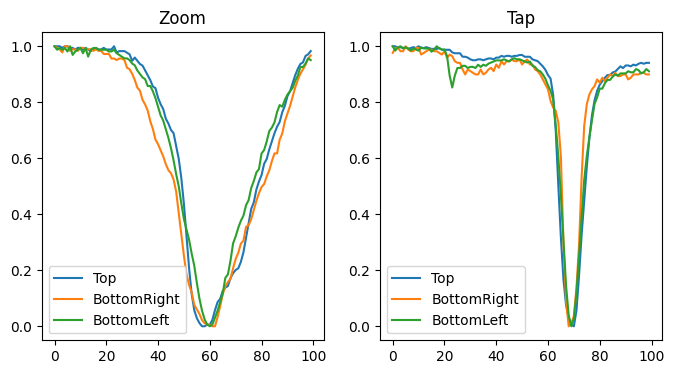

In [8]:
filtered_taps = list(filter(lambda x: x['gesture'] == Gestures.TAP, combined))
filtered_zooms = list(filter(lambda x: x['gesture'] == Gestures.ZOOM_IN, combined))

tap_gesture = random.choice(filtered_taps)
tap_gesture = filtered_taps[166]
tap_idx = filtered_taps.index(tap_gesture)

zoom_gesture = random.choice(filtered_zooms)
zoom_gesture = filtered_zooms[135]
zoom_idx = filtered_zooms.index(zoom_gesture)

print("Tap Gesture idx: %d" % tap_idx)
print("Zoom Gesture idx: %d" % zoom_idx)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].set_title("Zoom")
axs[0].plot(zoom_gesture['data'])
axs[0].legend(['Top', 'BottomRight', 'BottomLeft'])
axs[1].set_title("Tap")
axs[1].plot(tap_gesture['data'])
axs[1].legend(['Top', 'BottomRight', 'BottomLeft'])
fig.savefig('output_figures/tap_zoom_comparison.svg')
fig.show()

(100, 3)


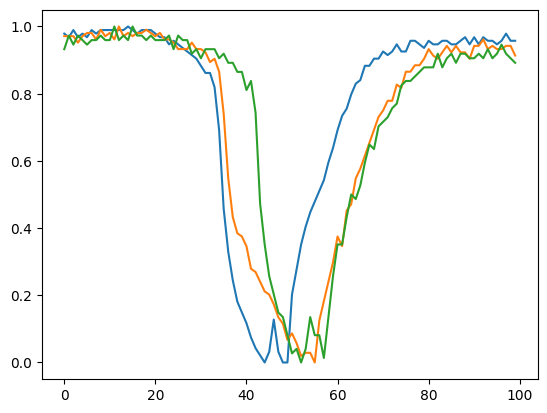

In [10]:
# Visualisation for CNN
one_sample = x_train[300]
print(one_sample.shape)
plt.plot(one_sample)
plt.savefig('output_figures/sample_graph.svg')
plt.show()

(100, 3)
(3, 100)


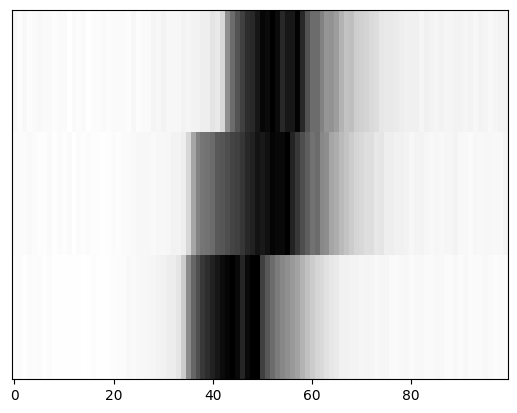

In [11]:
reshaped_sample = one_sample.reshape((100, 3))
reshaped_sample = np.rot90(one_sample, k=1)
print(one_sample.shape)
print(reshaped_sample.shape)
# plt.plot(one_sample[:,0])
plt.imshow(1 - reshaped_sample, cmap='Greys', interpolation='nearest', aspect='auto')
plt.yticks([])
plt.savefig('output_figures/sample_heatmap.svg')
plt.show()

Nee # Training times:
| GPU   | CPU   |
|-------|-------|
| 18.5s | 12.3s |

In [47]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

def build_lstm_stateless_model(lstm_units, dense_1_units, dense_1, dropout, bidirectional, input_shape, num_classes = len(Gestures)):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model = keras.Sequential(name="LSTM_Stateless")

    model.add(layers.Input(shape=input_shape, dtype=np.float32, name="sensor_image"))

    if bidirectional:
        model.add(layers.Bidirectional(layers.LSTM(units=lstm_units, name="lstm_bidirectional", time_major=False, return_sequences=True)))
    else:
        model.add(layers.LSTM(units=lstm_units, name="lstm", time_major=False, return_sequences=True))

    # Extra
    if dropout:
        model.add(layers.Dropout(rate=0.5, name="dropout"))

    model.add(layers.Flatten())

    # TODO: Try this dense layer
    if dense_1:
        model.add(layers.Dense(units=dense_1_units, activation='relu', name="dense_1"))

        if dropout:
            model.add(layers.Dropout(rate=0.5, name="dropout_2"))


    # Output stage
    model.add(layers.Dense(num_classes, activation="softmax", name="predictions"))
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    model.summary()
    return model

def build_tuning_lstm_stateless_model(hp):
    lstm_units = hp.Choice('units', [32, 64, 128, 256, 512, 1024])
    dense_1_units = hp.Choice('units', [16, 32, 64, 128, 256, 512, 1024])
    dropout = hp.Boolean("dropout")
    dense_1 = hp.Boolean("dense_1")
    model = build_lstm_stateless_model(lstm_units, dense_1_units, dense_1, dropout, input_shape=rnn_shape)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    return model


In [27]:
with tf.device(device):
    start = time.perf_counter()
    tuner = keras_tuner.RandomSearch(build_tuning_lstm_stateless_model, objective='val_loss', max_trials=20)
    tuner.search(x_train_rnn, y_train, epochs=300, batch_size=16, shuffle=False, validation_data=(x_test_rnn, y_test))

    end = time.perf_counter()
    print("Tuning took %0.1f seconds" % (end - start))


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json


NameError: name 'x_train_rnn' is not defined

In [ ]:
tuner.get_best_models()[0]

In [49]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    early_stop_cb = EarlyStopping(
        monitor='val_categorical_accuracy',
        mode='max',
        patience=10
    )

    start = time.perf_counter()
    # Do we need to reset the states inbetween?

    model_lstm_stateless = build_lstm_stateless_model(64, 128, dense_1=False, dropout=True, bidirectional=False, input_shape=rnn_shape, num_classes=len(filtered_gestures_list))
    model_lstm_stateless.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae', 'categorical_accuracy'])

    print(x_train.shape)
    print(y_train.shape)
    lstm_stateless_history = model_lstm_stateless.fit(x_train, y_train, epochs=80, batch_size=16, shuffle=False, validation_data=(x_test, y_test), callbacks=[early_stop_cb], verbose=0)

    end = time.perf_counter()
    print("Training took %0.1f seconds" % (end - start))


Model: "LSTM_Stateless"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           17408     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 flatten_17 (Flatten)        (None, 6400)              0         
                                                                 
 predictions (Dense)         (None, 10)                64010     
                                                                 
Total params: 81418 (318.04 KB)
Trainable params: 81418 (318.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
(1494, 100, 3)
(1494, 10)
Training took 26.0 seconds


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/cmtt1

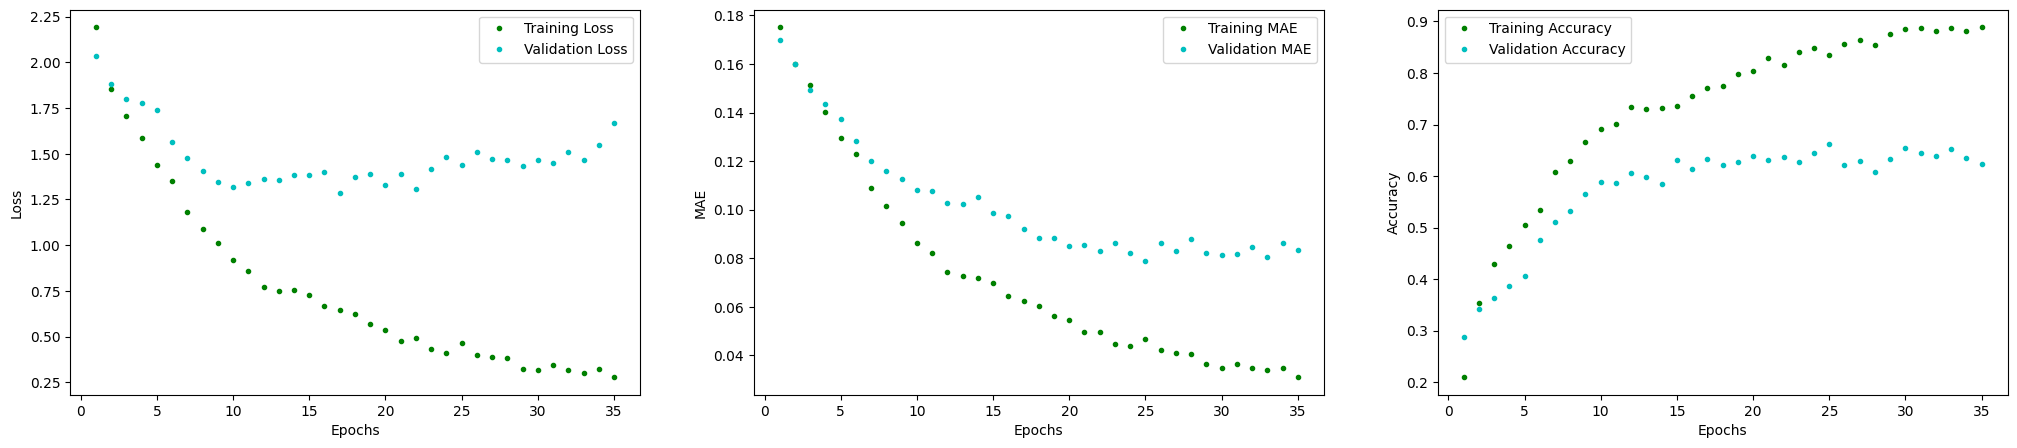

In [15]:
plot_history(lstm_stateless_history)

In [16]:
score = model_lstm_stateless.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.6683435440063477
Test accuracy: 0.6231231093406677


In [35]:
font = ImageFont.truetype("RobotoSlab-VariableFont_wght.ttf", 32)
visualkeras.layered_view(model_lstm_stateless, font=font, min_xy=160, scale_z=1, spacing=50, legend=True, to_file='output_figures/visual_lstm_stateless.png').show()

TypeError: 'int' object is not iterable

In [ ]:
y_pred = model_lstm_stateless.predict(x_test)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=filtered_gestures_list, xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_lstm.svg', bbox_inches="tight")

plt.show()

In [140]:
# K-Fold validation
model = build_lstm_stateless_model(64, 64, False, True, False, rnn_shape)
# (acc_per_fold_five, loss_per_fold_five, confusion_per_fold_five) = kfold_cross_validation(model, combined, num_folds=5, expected_input_shape=(100, 3))
(acc_per_fold_ten, loss_per_fold_ten, confusion_per_fold_ten) = kfold_cross_validation(model, combined, num_folds=10, expected_input_shape=(100, 3))

Model: "LSTM_Stateless"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 64)           17408     
                                                                 
 dropout (Dropout)           (None, 100, 64)           0         
                                                                 
 flatten_36 (Flatten)        (None, 6400)              0         
                                                                 
 predictions (Dense)         (None, 10)                64010     
                                                                 
Total params: 81418 (318.04 KB)
Trainable params: 81418 (318.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


INFO:CSE3000:Fold No. 1


[ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 27
 28 29 30]
10/10 - 0s - loss: 1.4788 - acc: 0.6990 - mae: 0.0650 - categorical_accuracy: 0.6990 - 251ms/epoch - 25ms/step
10/10 [==============================] - 0s 3ms/step


INFO:CSE3000:Fold No. 2


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 25
 26 27 29 30]
10/10 - 0s - loss: 1.8685 - acc: 0.7319 - mae: 0.0557 - categorical_accuracy: 0.7319 - 250ms/epoch - 25ms/step
10/10 [==============================] - 0s 3ms/step


INFO:CSE3000:Fold No. 3


[ 0  1  2  3  4  6  7  8  9 10 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30]
9/9 - 0s - loss: 2.2646 - acc: 0.7190 - mae: 0.0622 - categorical_accuracy: 0.7190 - 250ms/epoch - 28ms/step
9/9 [==============================] - 0s 3ms/step


INFO:CSE3000:Fold No. 4


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
7/7 - 0s - loss: 3.0265 - acc: 0.5919 - mae: 0.0830 - categorical_accuracy: 0.5919 - 249ms/epoch - 36ms/step
7/7 [==============================] - 0s 3ms/step


INFO:CSE3000:Fold No. 5


[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 20 21 22 23 24 25 26
 27 28 29 30]
6/6 - 0s - loss: 2.6716 - acc: 0.5759 - mae: 0.0838 - categorical_accuracy: 0.5759 - 222ms/epoch - 37ms/step
6/6 [==============================] - 0s 3ms/step


INFO:CSE3000:Fold No. 6


[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 23 24 25 26
 27 28 29 30]
7/7 - 0s - loss: 1.2251 - acc: 0.7190 - mae: 0.0569 - categorical_accuracy: 0.7190 - 237ms/epoch - 34ms/step
7/7 [==============================] - 0s 3ms/step


INFO:CSE3000:Fold No. 7


[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 25 26
 27 28 29 30]
7/7 - 0s - loss: 2.0025 - acc: 0.6650 - mae: 0.0730 - categorical_accuracy: 0.6650 - 234ms/epoch - 33ms/step
7/7 [==============================] - 0s 3ms/step


INFO:CSE3000:Fold No. 8


[ 0  1  2  3  4  5  6  7 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30]
6/6 - 3s - loss: 3.2699 - acc: 0.5632 - mae: 0.0899 - categorical_accuracy: 0.5632 - 3s/epoch - 438ms/step
6/6 [==============================] - 0s 5ms/step


INFO:CSE3000:Fold No. 9


[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 28 29 30]
5/5 - 0s - loss: 2.3766 - acc: 0.6494 - mae: 0.0691 - categorical_accuracy: 0.6494 - 242ms/epoch - 48ms/step
5/5 [==============================] - 0s 4ms/step


INFO:CSE3000:Fold No. 10


[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 20 21 22 24 25 26
 27 28 29 30]
9/9 - 0s - loss: 2.8782 - acc: 0.6875 - mae: 0.0627 - categorical_accuracy: 0.6875 - 257ms/epoch - 29ms/step
9/9 [==============================] - 0s 3ms/step


In [103]:
print("5-fold")
print(acc_per_fold_five)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold_five), np.std(acc_per_fold_five)))
print(np.average(loss_per_fold_five))

print("10-fold")
print(acc_per_fold_ten)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold_ten), np.std(acc_per_fold_ten)))
print(np.average(loss_per_fold_ten))

5-fold
[70.45454382896423, 63.782697916030884, 69.0773069858551, 57.63157606124878, 69.48356628417969]
Acc: 66.086 std: 4.824
2.5132263898849487
10-fold
[70.56856155395508, 71.6088354587555, 64.96350169181824, 58.29596519470215, 62.82722353935242, 80.95238208770752, 68.93203854560852, 54.0229856967926, 61.68830990791321, 73.52941036224365]
Acc: 66.739 std: 7.538
2.421838653087616


### LSTM 64 units Dense 32 units
Acc: 68.458
Std: 3.241

### LSTM 64 units
Acc: 67.269
Std: 3.778

### LSTM 128 units Dense 64 units
Acc: 67.238
Std: 3.597

### LSTM Bidirectional 128 units Dense 64 units
Acc: 67.432
Std: 4.429


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f9bd00bb3a0>


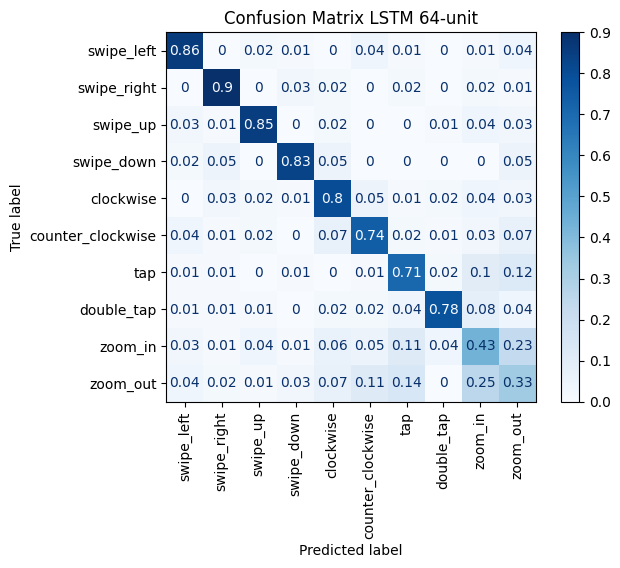

In [142]:
overall_confusion = np.zeros(confusion_per_fold[0].shape)
for conf in confusion_per_fold:
    overall_confusion = np.add(overall_confusion, conf)

# Normalize predictions
normalized_confusion = overall_confusion / overall_confusion.sum(axis=1, keepdims=1)
normalized_confusion = normalized_confusion.round(decimals=2)

ConfusionMatrixDisplay(normalized_confusion, display_labels=filtered_gestures_list).plot(cmap='Blues', xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM 64-unit")
plt.savefig('output_figures/confusion_matrix_lstm.svg', bbox_inches="tight")

plt.show()

With A3 data: 75.370 std: 3.365
With A3 data (reshaped to (20, 15)): 79.422 std: 2.424

In [40]:
with tf.device(device_name=device):
    run_model = tf.function(lambda x: model_lstm_stateless(x))
    # This is important, let's fix the input size.
    BATCH_SIZE = 1
    STEPS = 100
    INPUT_SIZE = 3
    concrete_func = run_model.get_concrete_function(
        tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model_lstm_stateless.inputs[0].dtype))

    MODEL_DIR = "keras_lstm"
    model_lstm_stateless.save(MODEL_DIR, signatures=concrete_func)

    # Convert to tflite model
    converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
    # converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm_stateless)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    tflite_model = converter.convert()
    open("lstm_model.tflite", "wb").write(tflite_model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.experimental_new_converter = True

    def representative_dataset_generator():
        for value in x_test:
            yield [np.array(value, dtype=np.float32, ndmin=3)]

    converter.representative_dataset = representative_dataset_generator
    tflite_model_quantized = converter.convert()

    open("lstm_model_quantized.tflite", "wb").write(tflite_model_quantized)

model_size = os.path.getsize("lstm_model.tflite")
quantized_size = os.path.getsize("lstm_model_quantized.tflite")
print("Normal model size: %d bytes (%.2f Kb)" % (model_size, float(model_size / 1000)))
print("Quantized model size: %d bytes (%.2f Kb)" % (quantized_size, float(quantized_size / 1000)))
print("Difference: %d bytes" % (model_size - quantized_size))

!xxd -i lstm_model_quantized.tflite > lstm_model_quantized.cc
!xxd -i lstm_model.tflite > lstm_model.cc

INFO:tensorflow:Assets written to: keras_lstm/assets


INFO:tensorflow:Assets written to: keras_lstm/assets
2023-06-14 14:55:41.026819: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-14 14:55:41.026925: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-14 14:55:41.027655: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: keras_lstm
2023-06-14 14:55:41.198825: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-06-14 14:55:41.198852: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: keras_lstm
2023-06-14 14:55:41.626188: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-06-14 14:55:41.933056: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: keras_lstm
2023-06-14 14:55:41.991042: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve 

Normal model size: 657392 bytes (657.39 Kb)
Quantized model size: 172104 bytes (172.10 Kb)
Difference: 485288 bytes


In [18]:
# TFLite model Interpreter
tflite_test = tf.lite.Interpreter('lstm_model_quantized.tflite')
tflite_test.allocate_tensors()

input_index = tflite_test.get_input_details()[0]["index"]
output_index = tflite_test.get_output_details()[0]["index"]

predictions = []
one_sample = x_test[15]
for el in one_sample:
    for s in el:
        print("%0.3f, " % s, end='')
print("")



0.941, 0.927, 1.000, 0.931, 0.919, 0.991, 0.961, 0.911, 0.982, 0.941, 0.911, 0.982, 0.951, 0.902, 0.991, 0.931, 0.902, 0.982, 0.941, 0.919, 0.964, 0.931, 0.902, 0.991, 0.931, 0.894, 0.991, 0.922, 0.886, 0.964, 0.922, 0.894, 0.955, 0.912, 0.870, 0.964, 0.902, 0.870, 0.945, 0.892, 0.821, 0.927, 0.863, 0.797, 0.918, 0.824, 0.772, 0.918, 0.794, 0.756, 0.909, 0.775, 0.724, 0.882, 0.745, 0.699, 0.873, 0.706, 0.659, 0.818, 0.676, 0.634, 0.827, 0.637, 0.569, 0.773, 0.608, 0.553, 0.755, 0.549, 0.496, 0.709, 0.520, 0.423, 0.673, 0.471, 0.358, 0.609, 0.402, 0.293, 0.582, 0.333, 0.211, 0.545, 0.265, 0.163, 0.500, 0.196, 0.114, 0.418, 0.147, 0.057, 0.364, 0.059, 0.000, 0.291, 0.029, 0.033, 0.255, 0.000, 0.081, 0.173, 0.039, 0.163, 0.091, 0.118, 0.220, 0.045, 0.245, 0.325, 0.000, 0.353, 0.350, 0.009, 0.441, 0.407, 0.064, 0.490, 0.366, 0.109, 0.480, 0.325, 0.218, 0.343, 0.341, 0.282, 0.304, 0.350, 0.336, 0.275, 0.358, 0.345, 0.412, 0.472, 0.255, 0.500, 0.561, 0.227, 0.588, 0.650, 0.227, 0.647, 0.699,

In [38]:
x_value_tensor = tf.convert_to_tensor([one_sample], dtype=np.float32)
tflite_test.set_tensor(input_index, x_value_tensor)
tflite_test.invoke()
print(tflite_test.get_tensor(output_index)[0])

[0.92578125 0.         0.00390625 0.0703125 ]


In [26]:
for x_value in x_test:
    x_value_tensor = tf.convert_to_tensor([x_value], dtype=np.float32)
    tflite_test.set_tensor(input_index, x_value_tensor)

    tflite_test.invoke()

    predictions.append(tflite_test.get_tensor(output_index)[0])

for pred, act in zip(predictions, y_test):
    print("Predicted: %s, Actual: %s" % (Gestures(np.argmax(pred)), Gestures(np.argmax(act))))

Predicted: swipe_right, Actual: swipe_right
Predicted: swipe_right, Actual: swipe_up
Predicted: swipe_right, Actual: swipe_up
Predicted: swipe_right, Actual: swipe_up
Predicted: swipe_right, Actual: swipe_right
Predicted: swipe_down, Actual: swipe_down
Predicted: swipe_right, Actual: swipe_right
Predicted: swipe_left, Actual: swipe_left
Predicted: swipe_left, Actual: swipe_left
Predicted: swipe_right, Actual: swipe_up
Predicted: swipe_right, Actual: swipe_right
Predicted: swipe_down, Actual: swipe_down
Predicted: swipe_up, Actual: swipe_up
Predicted: swipe_down, Actual: swipe_down
Predicted: swipe_down, Actual: swipe_down
Predicted: swipe_left, Actual: swipe_left
Predicted: swipe_right, Actual: swipe_right
Predicted: swipe_left, Actual: swipe_left
Predicted: swipe_down, Actual: swipe_down
Predicted: swipe_left, Actual: swipe_left
Predicted: swipe_up, Actual: swipe_up
Predicted: swipe_left, Actual: swipe_left
Predicted: swipe_right, Actual: swipe_right
Predicted: swipe_left, Actual: swi

# Custom Conv-LSTM model:

In [14]:
# https://medium.com/neuronio/an-introduction-to-convlstm-55c9025563a7
def build_conv_lstm_model_new(input_shape = (100, 3), num_classes = len(Gestures)):
    model = keras.Sequential(name='Conv_LSTM_new')

    model.add(layers.Input(shape=input_shape, dtype=np.float32))
    model.add(layers.Reshape((10, 3, 5, 2))) # Should always be 300 when the product is taken
    model.add(layers.ConvLSTM2D(64, kernel_size=(2, 2), activation='relu'))
    # model.add(layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
    # model.add(keras.layers.Dropout(0.25))
    # model.add(layers.ConvLSTM1D(64, 4, activation='relu'))

    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())
    model.add(layers.Dense(num_classes, activation='softmax', name="predictions"))

    return model

In [7]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    early_stop_cb = EarlyStopping(
        monitor='val_categorical_accuracy',
        mode='max',
        patience=20
    )

    start = time.perf_counter()
    model_conv_lstm_new = build_conv_lstm_model_new(input_shape=rnn_shape, num_classes=len(filtered_gestures_list))
    model_conv_lstm_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae', 'categorical_accuracy'])
    model_conv_lstm_new.summary()

    conv_lstm_history_new = model_conv_lstm_new.fit(x_train, y_train, epochs=200, batch_size=32, shuffle=False, validation_data=(x_test, y_test), callbacks=[early_stop_cb], verbose=0)

    end = time.perf_counter()
    log.info("Training took %0.1f seconds" % (end - start))

Model: "Conv_LSTM_new"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 10, 3, 5, 2)       0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 2, 4, 64)          67840     
                                                                 
 dropout (Dropout)           (None, 2, 4, 64)          0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 1, 64)             131328    
                                                                 
 dropout_1 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 10)              

2023-06-16 15:53:47.388255: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0bd80660f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-16 15:53:47.388293: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-16 15:53:47.397065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-16 15:53:47.439319: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
INFO:CSE3000:Training took 68.8 seconds


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/cmtt1

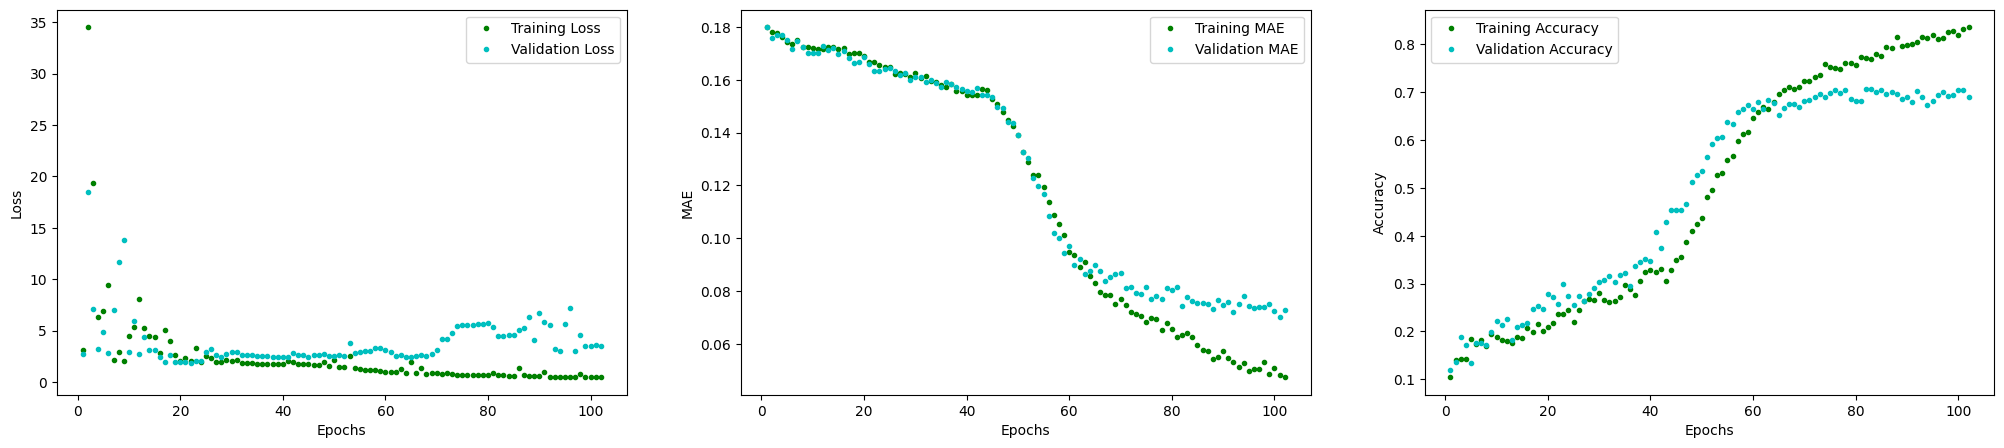

In [8]:
plot_history(conv_lstm_history_new)

In [9]:
score = model_conv_lstm_new.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2023-06-16 15:55:14.807098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:434] Loaded cuDNN version 8600
2023-06-16 15:55:15.427223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Test loss: 3.4874322414398193
Test accuracy: 0.6906906962394714


Shape: (10, 3, 5, 2)
acc: 0.69

Shape: (5, 3, 5, 4)
acc: 0.67

Shape: (20, 3, 5, 1)
acc: 0.67


In [18]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    # K-Fold validation
    model = build_conv_lstm_model_new(input_shape=rnn_shape)
    (acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model, combined, batch_size=16, num_folds=5, expected_input_shape=(100, 3))

INFO:CSE3000:Fold No. 1


[ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 27 29 30]
20/20 - 0s - loss: 2.1828 - acc: 0.7240 - mae: 0.0568 - categorical_accuracy: 0.7240 - 248ms/epoch - 12ms/step
20/20 [==============================] - 0s 5ms/step


INFO:CSE3000:Fold No. 2


[ 0  1  2  3  4  6  7  8  9 10 13 15 16 17 18 19 20 21 22 23 24 25 26 27
 28]
16/16 - 0s - loss: 1.1118 - acc: 0.6740 - mae: 0.0845 - categorical_accuracy: 0.6740 - 219ms/epoch - 14ms/step
16/16 [==============================] - 0s 5ms/step


INFO:CSE3000:Fold No. 3


[ 0  1  3  4  5  6  7  8  9 11 12 13 14 15 18 19 20 23 24 25 26 27 28 29
 30]
13/13 - 0s - loss: 0.9318 - acc: 0.7007 - mae: 0.0694 - categorical_accuracy: 0.7007 - 218ms/epoch - 17ms/step
13/13 [==============================] - 0s 5ms/step


INFO:CSE3000:Fold No. 4


[ 0  1  2  3  5  6  7 10 11 12 14 16 17 18 19 20 21 22 23 25 26 27 28 29
 30]
12/12 - 0s - loss: 1.5949 - acc: 0.5553 - mae: 0.1083 - categorical_accuracy: 0.5553 - 199ms/epoch - 17ms/step
12/12 [==============================] - 0s 5ms/step


INFO:CSE3000:Fold No. 5


[ 2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 20 21 22 24 25 26 28 29
 30]
14/14 - 0s - loss: 34.7162 - acc: 0.7254 - mae: 0.0565 - categorical_accuracy: 0.7254 - 213ms/epoch - 15ms/step
14/14 [==============================] - 0s 5ms/step


In [19]:
print(acc_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

[72.40259647369385, 67.40442514419556, 70.07481455802917, 55.52631616592407, 72.53521084785461]
Acc: 67.589 std: 6.314
8.10751360654831


# Conv-LSTM model:

In [21]:
def build_conv_lstm_model(input_shape = (100, 3), num_classes = len(Gestures)):
    model = keras.Sequential(name="Conv_LSTM")

    model.add(layers.Input(shape=input_shape, dtype=np.float32))
    model.add(layers.Reshape((20, 15)))
    model.add(keras.layers.TimeDistributed(keras.layers.Reshape((5, 3, 1))))
    model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(128, 2, activation='relu')))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(128, 2, activation='relu')))
    model.add(keras.layers.Dropout(0.25))
    # model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(128, 2, activation='relu')))
    # model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.TimeDistributed(keras.layers.Conv2D(64, kernel_size=(3, 1), activation='relu')))
    model.add(keras.layers.Reshape((20, 64)))
    model.add(keras.layers.LSTM(64))

    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Flatten())
    model.add(layers.Dense(num_classes, activation="softmax", name="predictions"))

    return model

In [22]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    early_stop_cb = EarlyStopping(
        monitor='val_categorical_accuracy',
        mode='max',
        patience=10
    )

    start = time.perf_counter()
    model_conv_lstm = build_conv_lstm_model(input_shape=rnn_shape, num_classes=len(filtered_gestures_list))
    model_conv_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae', 'categorical_accuracy'])
    model_conv_lstm.summary()

    conv_lstm_history = model_conv_lstm.fit(x_train, y_train, epochs=200, batch_size=16, shuffle=False, validation_data=(x_test, y_test), callbacks=[early_stop_cb])

    end = time.perf_counter()
    log.info("Training took %0.1f seconds" % (end - start))

Model: "Conv_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 20, 15)            0         
                                                                 
 time_distributed (TimeDist  (None, 20, 5, 3, 1)       0         
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 4, 2, 128)     640       
 stributed)                                                      
                                                                 
 dropout_9 (Dropout)         (None, 20, 4, 2, 128)     0         
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 3, 1, 128)     65664     
 stributed)                                                      
                                                         

KeyboardInterrupt: 

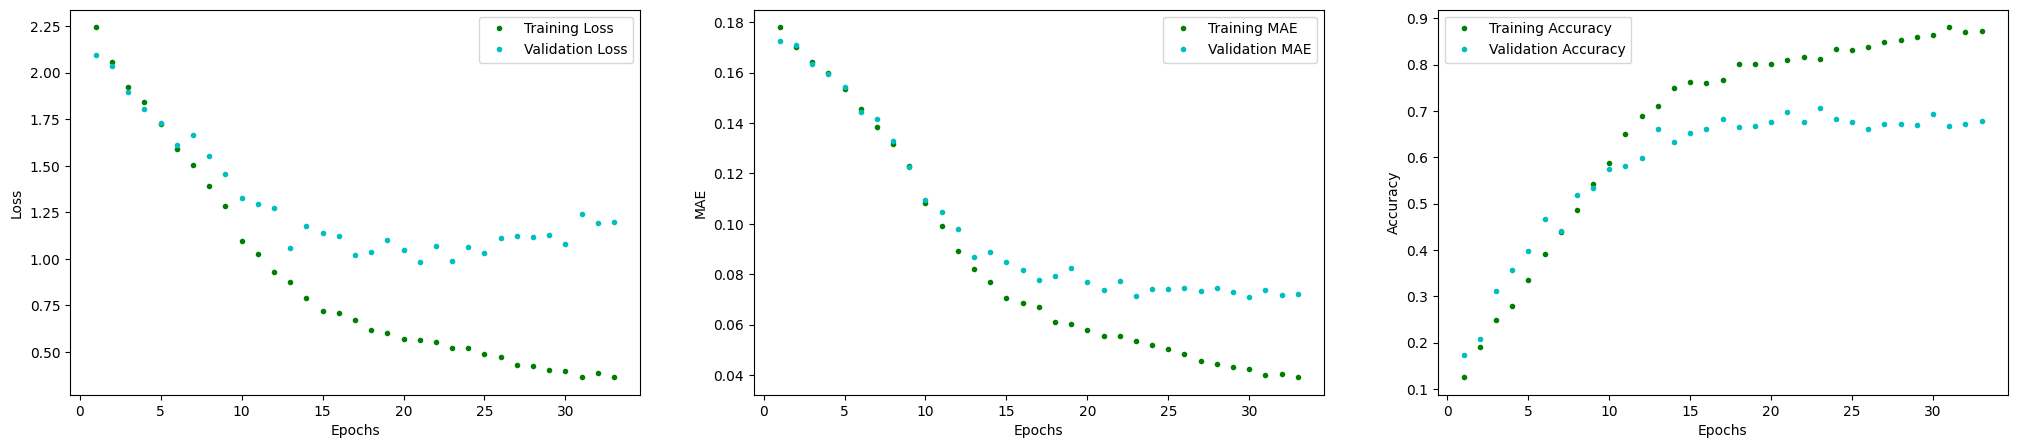

In [95]:
plot_history(conv_lstm_history)

In [13]:
score = model_conv_lstm.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5166919827461243
Test accuracy: 0.8709677457809448


15/15 [==============================] - 0s 3ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f118d8c7370>


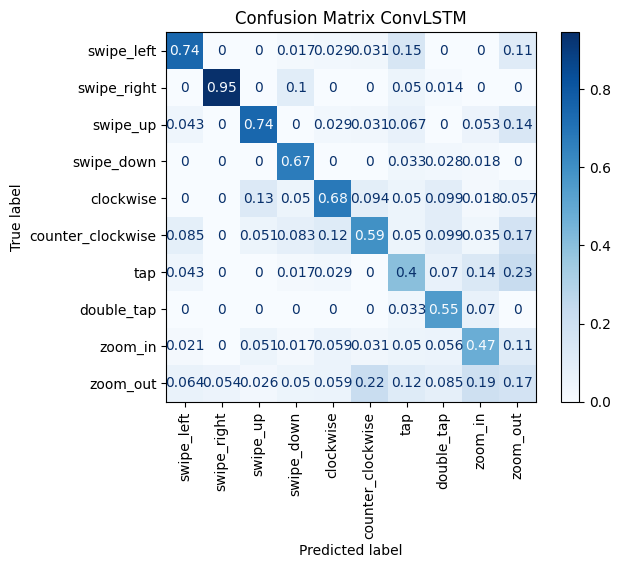

In [56]:
y_pred = model_conv_lstm.predict(x_test)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=filtered_gestures_list, xticks_rotation='vertical')

plt.title("Confusion Matrix ConvLSTM")
plt.savefig('output_figures/confusion_matrix_conv_lstm.svg', bbox_inches="tight")

plt.show()

In [23]:
# K-Fold validation
model = build_conv_lstm_model(input_shape=rnn_shape)
(acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model, combined, num_folds=5, expected_input_shape=(100, 3))

INFO:CSE3000:Fold No. 1


[ 0  1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 19 21 22 23 24 27 29 30]
20/20 - 0s - loss: 1.1174 - acc: 0.7321 - mae: 0.0563 - categorical_accuracy: 0.7321 - 315ms/epoch - 16ms/step
20/20 [==============================] - 0s 2ms/step


INFO:CSE3000:Fold No. 2


[ 0  1  2  3  4  6  7  8  9 10 13 15 16 17 18 19 20 21 22 23 24 25 26 27
 28]
16/16 - 0s - loss: 1.6483 - acc: 0.6700 - mae: 0.0679 - categorical_accuracy: 0.6700 - 314ms/epoch - 20ms/step
16/16 [==============================] - 0s 2ms/step


INFO:CSE3000:Fold No. 3


[ 0  1  3  4  5  6  7  8  9 11 12 13 14 15 18 19 20 23 24 25 26 27 28 29
 30]
13/13 - 0s - loss: 1.1619 - acc: 0.7257 - mae: 0.0585 - categorical_accuracy: 0.7257 - 282ms/epoch - 22ms/step
13/13 [==============================] - 0s 2ms/step


INFO:CSE3000:Fold No. 4


[ 0  1  2  3  5  6  7 10 11 12 14 16 17 18 19 20 21 22 23 25 26 27 28 29
 30]
12/12 - 0s - loss: 1.9713 - acc: 0.6605 - mae: 0.0697 - categorical_accuracy: 0.6605 - 304ms/epoch - 25ms/step
12/12 [==============================] - 0s 2ms/step


INFO:CSE3000:Fold No. 5


[ 2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 20 21 22 24 25 26 28 29
 30]
14/14 - 0s - loss: 1.4971 - acc: 0.6878 - mae: 0.0660 - categorical_accuracy: 0.6878 - 278ms/epoch - 20ms/step
14/14 [==============================] - 0s 2ms/step


In [24]:
print(acc_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

[73.21428656578064, 67.00201034545898, 72.56857752799988, 66.05263352394104, 68.77934336662292]
Acc: 69.523 std: 2.893
1.4791994094848633


Kernel sizes: 2, 2, (1, 3)
Acc: 70.445

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f9c00137250>


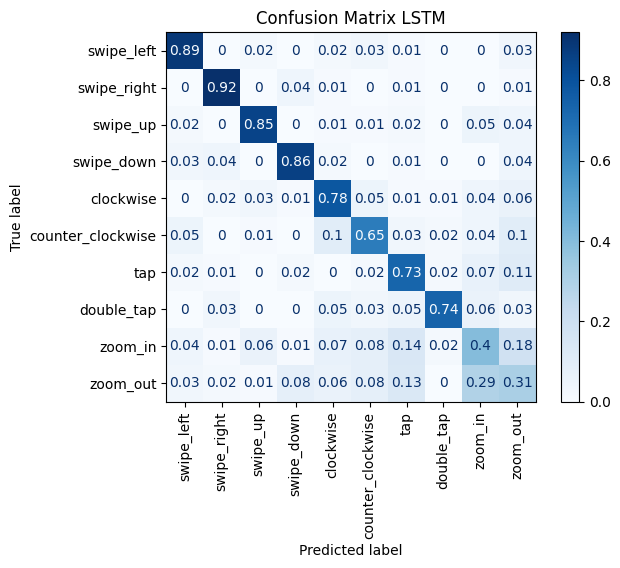

In [76]:
overall_confusion = np.zeros(confusion_per_fold[0].shape)
for conf in confusion_per_fold:
    overall_confusion = np.add(overall_confusion, conf)

# Normalize predictions
normalized_confusion = overall_confusion / overall_confusion.sum(axis=1, keepdims=1)
normalized_confusion = normalized_confusion.round(decimals=2)

ConfusionMatrixDisplay(normalized_confusion, display_labels=filtered_gestures_list).plot(cmap='Blues', xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_lstm.svg', bbox_inches="tight")

plt.show()

In [54]:
with tf.device(device_name=device):
    run_model = tf.function(lambda x: model_conv_lstm(x))
    # This is important, let's fix the input size.
    BATCH_SIZE = 1
    STEPS = 100
    INPUT_SIZE = 3
    concrete_func = run_model.get_concrete_function(
        tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model_conv_lstm.inputs[0].dtype))

    MODEL_DIR = "keras_conv_lstm"
    model_conv_lstm.save(MODEL_DIR, signatures=concrete_func)

    # Convert to tflite model
    converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
    # converter = tf.lite.TFLiteConverter.from_keras_model(model_lstm_stateless)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    tflite_model = converter.convert()
    open("conv_lstm_model.tflite", "wb").write(tflite_model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.experimental_new_converter = True

    def representative_dataset_generator():
        for value in x_test:
            yield [np.array(value, dtype=np.float32, ndmin=3)]

    converter.representative_dataset = representative_dataset_generator
    tflite_model_quantized = converter.convert()

    open("conv_lstm_model_quantized.tflite", "wb").write(tflite_model_quantized)

model_size = os.path.getsize("conv_lstm_model.tflite")
quantized_size = os.path.getsize("conv_lstm_model_quantized.tflite")
print("Normal model size: %d bytes (%.2f Kb)" % (model_size, float(model_size / 1000)))
print("Quantized model size: %d bytes (%.2f Kb)" % (quantized_size, float(quantized_size / 1000)))
print("Difference: %d bytes" % (model_size - quantized_size))

!xxd -i conv_lstm_model_quantized.tflite > conv_lstm_model_quantized.cc
!xxd -i conv_lstm_model.tflite > conv_lstm_model.cc

INFO:tensorflow:Assets written to: keras_conv_lstm/assets


INFO:tensorflow:Assets written to: keras_conv_lstm/assets
2023-06-14 15:39:27.021269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-06-14 15:39:27.021309: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-06-14 15:39:27.021421: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: keras_conv_lstm
2023-06-14 15:39:27.026570: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-06-14 15:39:27.026588: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: keras_conv_lstm
2023-06-14 15:39:27.043967: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-06-14 15:39:27.117832: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: keras_conv_lstm
2023-06-14 15:39:27.153632: I tensorflow/cc/saved_model/loader.cc:316] SavedModel lo

Normal model size: 504696 bytes (504.70 Kb)
Quantized model size: 141688 bytes (141.69 Kb)
Difference: 363008 bytes


2023-06-14 15:39:27.350614: I tensorflow/cc/saved_model/reader.cc:52] Reading SavedModel from: keras_conv_lstm
2023-06-14 15:39:27.355283: I tensorflow/cc/saved_model/reader.cc:106] Reading meta graph with tags { serve }
2023-06-14 15:39:27.355300: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: keras_conv_lstm
2023-06-14 15:39:27.369981: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-06-14 15:39:27.435235: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: keras_conv_lstm
2023-06-14 15:39:27.468022: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 117408 microseconds.
2023-06-14 15:39:27.555283: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2138] Estimated count of arithmetic ops: 9.043 M  ops, equivalently 4.521 M  MACs
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inferen

In [97]:
model_size = os.path.getsize("conv_lstm_model.tflite")
quantized_size = os.path.getsize("conv_lstm_model_quantized.tflite")
print("Normal model size: %d bytes" % model_size)
print("Quantized model size: %d bytes" % quantized_size)
print("Difference: %d bytes" % (model_size - quantized_size))

Normal model size: 504692 bytes
Quantized model size: 141688 bytes
Difference: 363004 bytes


# Stateful model:

In [46]:
def build_lstm_stateful_model(lstm_units, dense_1_units, dropout):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model = keras.Sequential(name="LSTM_Stateful")

    # Subject to change as we split up the data in fragments:
    model.add(layers.Input(batch_shape=(25, 4, 3), name="sensor_image"))
    model.add(layers.LSTM(units=lstm_units, batch_input_shape=(25, 4), stateful=True, name="lstm"))

    # Extra
    if dropout:
        model.add(layers.Dropout(rate=0.25, name="dropout"))

    model.add(layers.Dense(units=dense_1_units, activation='relu', name="dense_1"))

    # Output stage
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    model.summary()
    return model

In [47]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"
print(x_train_normalized.shape)

stateful_reshaped_x = x_train_normalized.reshape((-1 ,25, 4, 3))
print(stateful_reshaped_x.shape)

with tf.device(device):
    model_lstm_stateful = build_lstm_stateful_model(128, 128, True)
    model_lstm_stateful.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

    start = time.perf_counter()
    # Do we need to reset the states inbetween?
    lstm_stateful_history = model_lstm_stateful.fit(stateful_reshaped_x, y_train, epochs=200, batch_size=8, shuffle=False, validation_data=(x_test_normalized, y_test))

    end = time.perf_counter()
    print("Training took: %0.1f seconds" % (end - start))

(801, 100, 3)
(801, 25, 4, 3)
Model: "LSTM_Stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (25, 128)                 67584     
                                                                 
 dropout (Dropout)           (25, 128)                 0         
                                                                 
 dense_1 (Dense)             (25, 128)                 16512     
                                                                 
 predictions (Dense)         (25, 10)                  1290      
                                                                 
Total params: 85,386
Trainable params: 85,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-23 08:58:27.098068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-23 08:58:27.099137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-23 08:58:27.100035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "LSTM_Stateful" is incompatible with the layer: expected shape=(None, 4, 3), found shape=(None, 25, 4, 3)


In [ ]:
plot_history(lstm_stateful_history)

In [165]:
score = model_lstm_stateful.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "LSTM_Stateful" is incompatible with the layer: expected shape=(None, 4, 3), found shape=(None, 100, 3)


In [ ]:
# KFold
# K-Fold validation
model = build_lstm_stateful_model(128, 128, False)

(acc_per_fold, loss_per_fold, confusion_per_fold) = kfold_cross_validation(model, combined_x, combined_y, num_folds=5)

In [ ]:
print(acc_per_fold)
print("Acc: %.3f std: %.3f" % (np.average(acc_per_fold), np.std(acc_per_fold)))
print(np.average(loss_per_fold))

7/7 [==============================] - 0s 15ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f0fbaf8a580>


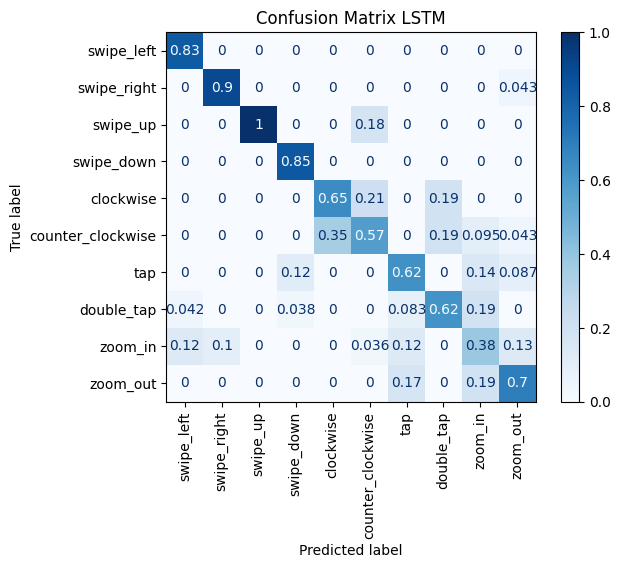

In [18]:
y_pred = model_lstm_stateful.predict(x_test_normalized)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_lstm.svg', bbox_inches="tight")

plt.show()

In [ ]:
visualkeras.layered_view(model_lstm_stateful, legend=True).show()

65


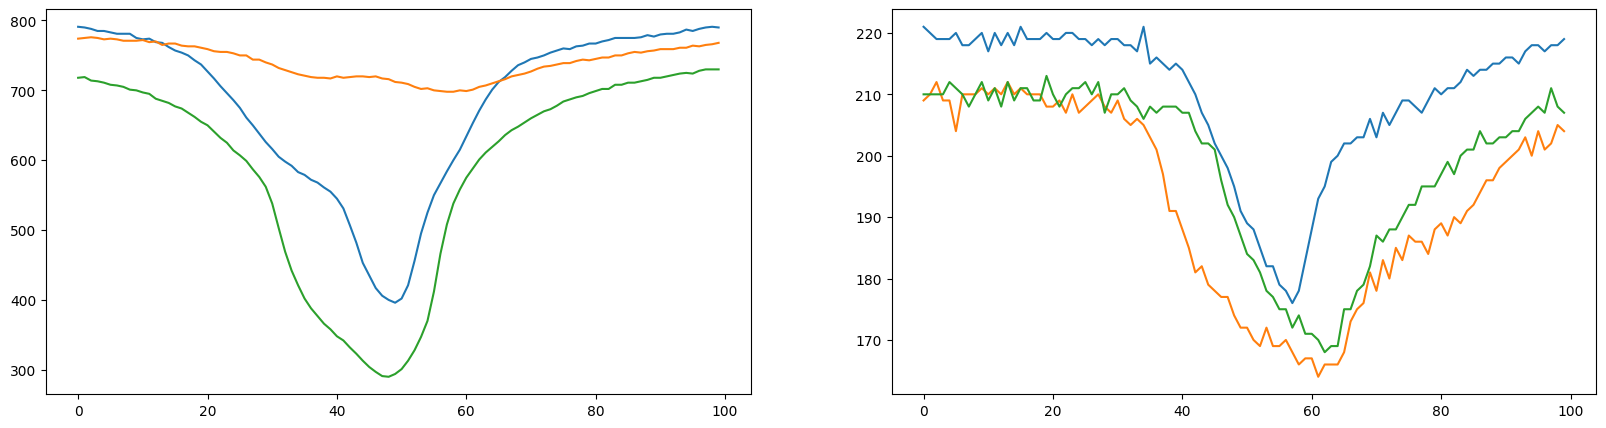

In [34]:
# taps = list(filter(lambda x: Gestures(x[1]) == Gestures.TAP, zip(x_train_normalized, y_train)))
# TODO: Remove the tap gesture that is noise
taps = load_gesture_samples(Gestures.TAP, Hand.right)
zooms = load_gesture_samples(Gestures.ZOOM_OUT, Hand.right)
print(len(taps))
random_tap = random.choice(taps)
random_zoom = random.choice(zooms)
# print(random_plot['candidate'])

# TODO: Maybe train a separate model for distinguishing the very confusion-heavy classes (Ensemble models)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(random_tap['data'])
axs[1].plot(random_zoom['data'])
plt.show()

Randomly selected gesture: 37
Candidate: E3


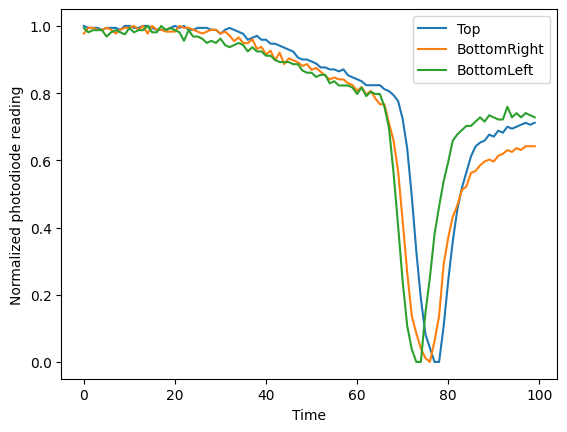

In [37]:
swipe_ups = load_gesture_samples(Gestures.SWIPE_UP, Hand.right)
random_select = random.randint(0, len(swipe_ups))
random_select = 37
print("Randomly selected gesture: %d" % random_select)
print("Candidate: %s" % swipe_ups[random_select]['candidate'])
selected_swipe_up = swipe_ups[random_select]['data']
scaler = MinMaxScaler((0, 1))
normalized_selected = scaler.fit_transform(selected_swipe_up)

plt.plot(normalized_selected)
plt.xlabel("Time")
plt.ylabel("Normalized photodiode reading")
plt.legend(['Top', 'BottomRight', 'BottomLeft'])
plt.savefig('output_figures/sample_graph.svg')
plt.show()

In [ ]:
print("\n\n================= Running on testing data: =================")
y_pred = model_lstm_stateful.predict(x_test_normalized)
for actual, pred in zip(y_test, y_pred):
    pred = Gestures(np.argmax(pred))
    actual = Gestures(np.argmax(actual))
    if pred == Gestures.SWIPE_RIGHT:
        print("Prediction: %s, actual: %s" % (pred, actual))

In [22]:
def build_gru_model(gru_units, dense_1_units, dense_1, dropout):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model = keras.Sequential(name="LSTM_Stateless")

    # Subject to change as we split up the data in fragments:
    # Stateless?
    model.add(layers.Input(shape=(100, 3), name="sensor_image"))
    model.add(layers.GRU(units=gru_units, name="gru"))
    # Stateful?
    # model_lstm_stateless.add(layers.Input(batch_shape=(100, 3, 1), name="sensor_image"))
    # model_lstm_stateless.add(layers.LSTM(units=128, stateful=True, name="lstm"))

    # Extra
    if dropout:
        model.add(layers.Dropout(rate=0.25, name="dropout"))

    if dense_1:
        model.add(layers.Dense(units=dense_1_units, activation='relu', name="dense_1"))

    # Output stage
    model.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    model.summary()
    return model

In [24]:
USE_GPU = True
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    start = time.perf_counter()
    # Do we need to reset the states inbetween?

    model_gru_stateless = build_gru_model(128, 256, True, True)
    model_gru_stateless.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])

    gru_history = model_gru_stateless.fit(x_train_normalized, y_train, epochs=200, batch_size=16, shuffle=False, validation_data=(x_test_normalized, y_test))

    end = time.perf_counter()
    print("Training took %0.1f seconds" % (end - start))

Model: "LSTM_Stateless"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               51072     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 predictions (Dense)         (None, 10)                2570      
                                                                 
Total params: 86,666
Trainable params: 86,666
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-22 19:28:47.640501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 19:28:47.642002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 19:28:47.642882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/39 [========================>.....] - ETA: 0s - loss: 2.3027 - acc: 0.1174 - mae: 0.1799

2023-05-22 19:28:49.658348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 19:28:49.659920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 19:28:49.661126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

39/39 [==============================] - 2s 21ms/step - loss: 2.3018 - acc: 0.1140 - mae: 0.1799 - val_loss: 2.2722 - val_acc: 0.1493 - val_mae: 0.1793
Epoch 2/200
39/39 [==============================] - 0s 12ms/step - loss: 2.2754 - acc: 0.1573 - mae: 0.1793 - val_loss: 2.2211 - val_acc: 0.1940 - val_mae: 0.1781
Epoch 3/200
39/39 [==============================] - 0s 10ms/step - loss: 2.1989 - acc: 0.1782 - mae: 0.1764 - val_loss: 2.0982 - val_acc: 0.1978 - val_mae: 0.1730
Epoch 4/200
39/39 [==============================] - 0s 10ms/step - loss: 2.1260 - acc: 0.1958 - mae: 0.1724 - val_loss: 2.0776 - val_acc: 0.2313 - val_mae: 0.1722
Epoch 5/200
39/39 [==============================] - 0s 11ms/step - loss: 2.1298 - acc: 0.2022 - mae: 0.1720 - val_loss: 2.0980 - val_acc: 0.2276 - val_mae: 0.1735
Epoch 6/200
39/39 [==============================] - 0s 10ms/step - loss: 2.0504 - acc: 0.2809 - mae: 0.1700 - val_loss: 2.0420 - val_acc: 0.2463 - val_mae: 0.1697
Epoch 7/200
39/39 [=========

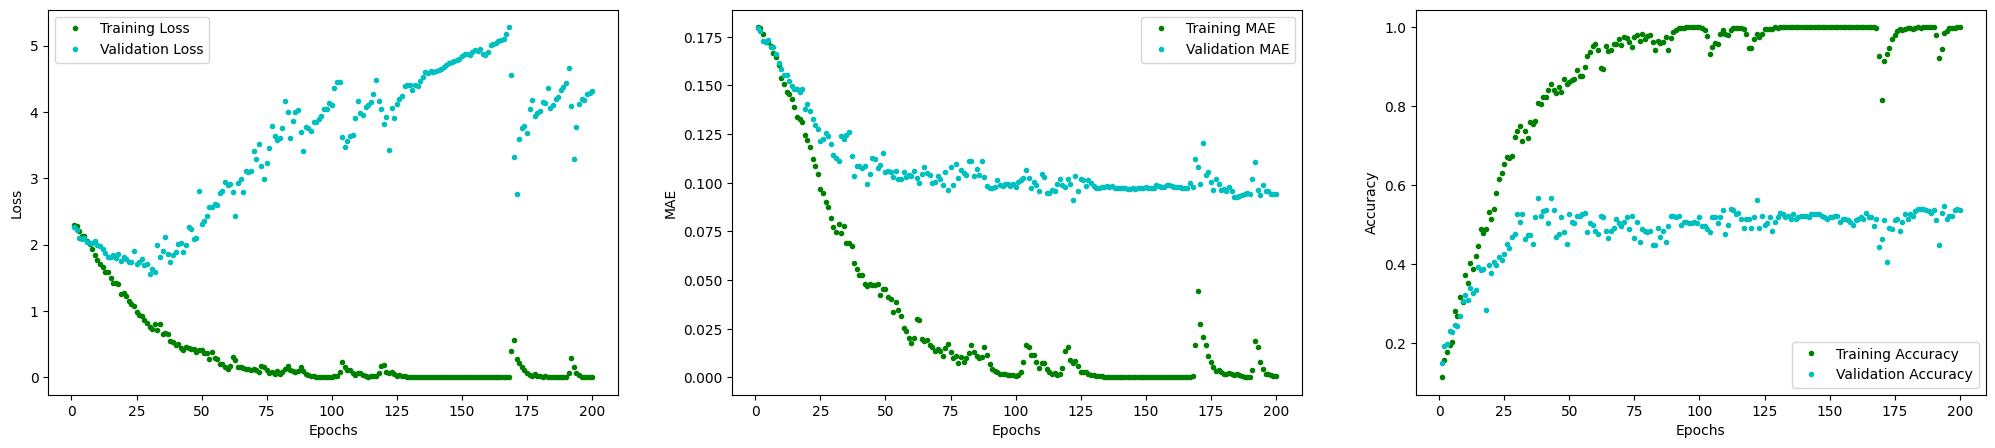

In [25]:
plot_history(gru_history)

In [26]:
score = model_gru_stateless.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 4.310211658477783
Test accuracy: 0.5373134613037109


9/9 [==============================] - 0s 8ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7f4f36598f70>


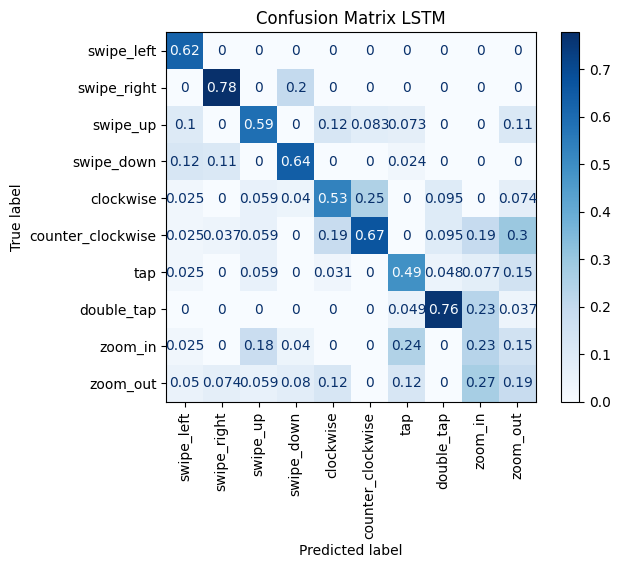

In [28]:
y_pred = model_gru_stateless.predict(x_test_normalized)
ConfusionMatrixDisplay.from_predictions(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='pred', cmap='Blues', display_labels=Gestures, xticks_rotation='vertical')

plt.title("Confusion Matrix LSTM")
plt.savefig('output_figures/confusion_matrix_gru.svg', bbox_inches="tight")

plt.show()

In [119]:
def build_simple_rnn_model(shape) -> keras.Model:
    model = keras.Sequential(name='Simple_RNN')

    model.add(layers.SimpleRNN(units=16, input_shape=shape, activation='linear'))
    model.add(layers.Dense(units=len(Gestures), activation='softmax'))

    return model

In [149]:
simple_rnn = build_simple_rnn_model(rnn_shape)
simple_rnn.compile(optimizer='adam', loss='mse', metrics=['acc', 'mae'])

simple_rnn_history = simple_rnn.fit(x_train_rnn, y_train, batch_size=16, epochs=400, validation_data=(x_test_rnn, y_test))

Epoch 1/400
42/42 [==============================] - 2s 19ms/step - loss: 0.1011 - acc: 0.0761 - mae: 0.1813 - val_loss: 0.0938 - val_acc: 0.1174 - val_mae: 0.1788
Epoch 2/400
42/42 [==============================] - 1s 17ms/step - loss: 0.0941 - acc: 0.1035 - mae: 0.1803 - val_loss: 0.0923 - val_acc: 0.1495 - val_mae: 0.1789
Epoch 3/400
42/42 [==============================] - 1s 16ms/step - loss: 0.0924 - acc: 0.1202 - mae: 0.1798 - val_loss: 0.0915 - val_acc: 0.1388 - val_mae: 0.1790
Epoch 4/400
42/42 [==============================] - 1s 17ms/step - loss: 0.0914 - acc: 0.1187 - mae: 0.1794 - val_loss: 0.0909 - val_acc: 0.1352 - val_mae: 0.1789
Epoch 5/400
42/42 [==============================] - 1s 16ms/step - loss: 0.0907 - acc: 0.1476 - mae: 0.1789 - val_loss: 0.0905 - val_acc: 0.1815 - val_mae: 0.1785
Epoch 6/400
42/42 [==============================] - 1s 17ms/step - loss: 0.0901 - acc: 0.1674 - mae: 0.1785 - val_loss: 0.0902 - val_acc: 0.1815 - val_mae: 0.1783
Epoch 7/400
42/4

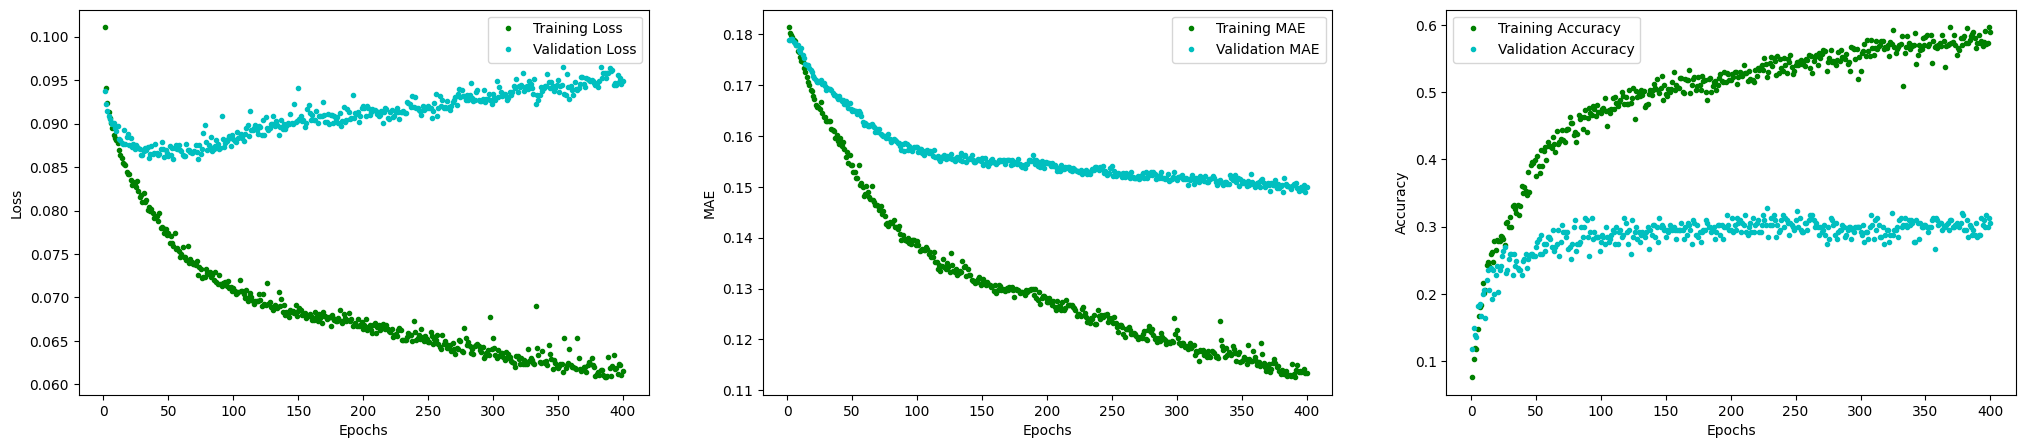

In [150]:
plot_history(simple_rnn_history)

In [151]:
score = simple_rnn.evaluate(x_test_rnn, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0948731079697609
Test accuracy: 0.30604982376098633
